# Bayesian Change Point Model

## Including the Code

In [1]:
%%capture
%run 'BCPM_Implementation.ipynb'

# Generative Model

Bayesian change point model is an example of hierarchical hidden Markov models. The model is described by three sets of variables: switches, latent dynamics and observations, denoted respectively by $s_t$, $h_t$ and $v_t$. The switch variable $s_t$ has a discrete space. Conditioned on the switches, $h_t$ is a Markov chain. Furthermore, observations $v_t$ are conditioned on latent states $h_t$. The graphical representation of the resulting model is given below:.


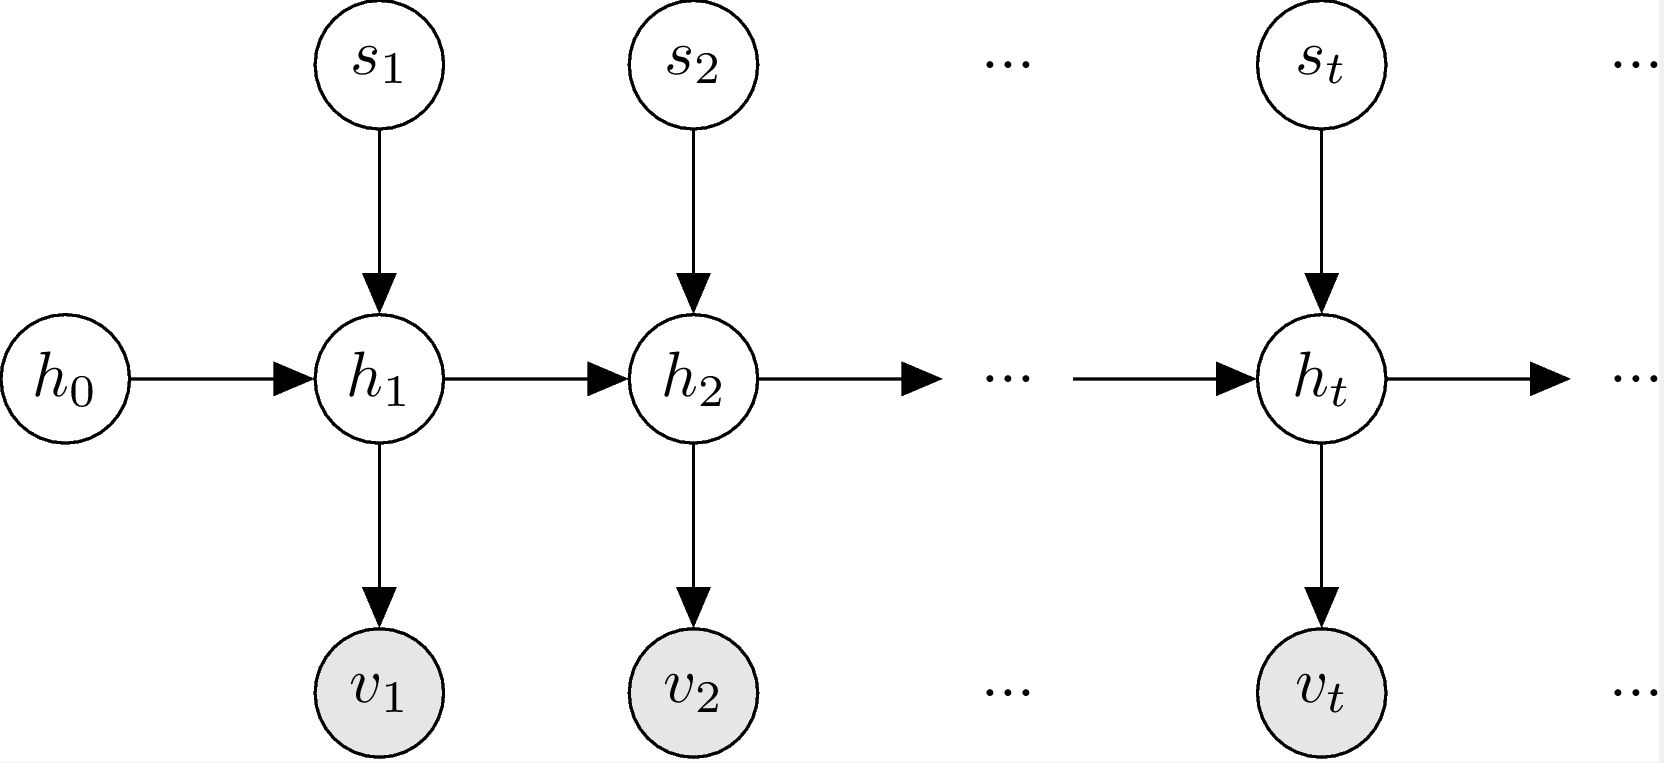

In [2]:
from IPython.display import Image
Image(filename='../etc/graphical_model.png', width=600, height=200)

In this notebook, we focus on a special kind of change point models, in which $s_t$ is a binary variable (Such models are also known as _reset_ models). The initial latent variable $h_0$ is drawn from reset model $\Omega(h)$. At each time step $t$, the switch $s_t$ is either _on_ or _off_. In the former case, or when $s_t=1$, the present is isolated from the past and $h_t$ is re-drawn from the reset model. When $s_t=0$, the model continues with the current latent dynamics. Two other model assumptions are _(i)_ the switches are conditionally independent from all other variables and _(ii)_ the observation at time t, $v_t$, is assumed to be a random variable sampled from the observation model $\Theta(v)$ with an unknown parameter $h_t$. Thus, the complete generative model is given as:

\begin{align}
h_0  &\sim \Omega(h_0;w) \\
s_t  &\sim \mathcal{BE}(s_t;\pi) \\
h_t | s_t, h_{t-1}  &\sim [s_{t}=0] \delta(h_{t} - h_{t-1}) + [s_{t}=1] \Omega(h_t;w)\\
v_t | h_t  &\sim \Theta(v_t; h_t) 
\end{align}

where $\delta$ is Dirac delta function, and $\mathcal{BE}(\cdot;\pi)$ is the Bernoulli distribution with parameter $\pi$ and defined as follows: 

\begin{equation}
\mathcal{BE} (s; \pi) =  \exp \left( s\log\pi + (1-s)\log (1-\pi)   \right) 
\end{equation}

# Model Specifications
Inference and parameter learning methods can be implemented independent of the observation model $\Theta$ and reset model $\Omega$. Depending on the application and the characteristics of the data set, these models can be set appropriately. It is worthwhile to note that the computations are typically easier if the models are discrete or $\Theta$ is the conjugate prior of $\Omega$. Below, we see two different model specifications.

## Gamma-Poisson (GP) Model
Given a data set consisting of nonnegative integers, this model assumes that the observation $v_t$ is a Poisson random variable with intensity parameter $h_t$. To model the uncertainty over Poisson intensity, we use gamma distribution since both its support and Poisson intensity parameters are positive real numbers. Consequently, reset hyperparameter is a couple of real numbers, ${w=(a,b)}$, which denote the shape and scale parameters of gamma distribution. Also, forward and backward messages in this setup store a mixture of gamma potentials over $h_t$. Below are the probability mass/distribution functions of Poisson and gamma distributions: 

\begin{alignat}{3}
\Omega(h;w) &= \mathcal{G}(h;a,b) &&= \frac{{b}^{a}}{\Gamma(a)} h^{a-1} e^{-bh} \\
\Theta(v; h) &=	\mathcal{P}(v; h) &&= \frac{h^v e^{-h}}{\Gamma(v+1)}
\end{alignat}

## Dirichlet-Multinomial (DM) Model
If the observations are $K\geq2$ dimensional vectors of nonnegative integers, the observations could be modeled as multinomial random variables. This assumption enforces the latent variable $h_t$, or the parameter of the multinomial distribution, to be a $K\geq2$ dimensional vector whose elements are nonnegative and sum up to 1. Dirichlet distribution fits this setup very well since it is a distribution over $K-$simplex:

\begin{alignat}{3}
\Omega(h;w) &= \mathcal{Dir}(h; w) &&= \frac{\Gamma \left( \sum_{i=1}^M w_k \right)} {\sum_{i=1}^M \Gamma(w_i)} \prod_{i=1}^M h_{i}^{w_i-1} \\
\Theta(v; h) &= \mathcal{M}(v; h) &&= \frac{\Gamma(\sum_i v_i+1)}{\prod_i \Gamma(v_i+1)} \prod_i h_i^{v_i} 
\end{alignat}

# Examples


### Synthetic Data 

filtering...
smoothing...
online smoothing...


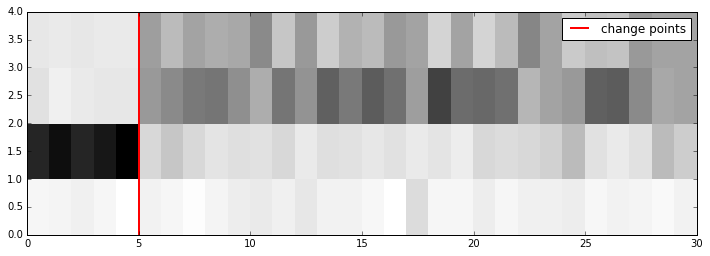

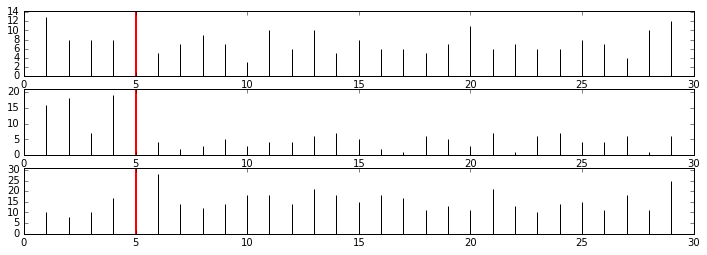

done.


In [3]:
work_dir = '/tmp/demo'
find_or_create(work_dir)

# Generate Model
t = 30
p1 = 0.05
m = 4
n = 3
model = Model.default_model(p1, m, n)
model.save(work_dir + '/model.txt')

# Generate Data
data = model.generate_data(t)
data.save(work_dir + '/data')

# Change Point Estimations
print('filtering...')
result_f = model.filter(data.v)
result_f.save(work_dir + '/filtering')

print('smoothing...')
result_s = model.smooth(data.v)
result_s.save(work_dir + '/smoothing')

print('online smoothing...')
result_o = model.online_smooth(data.v, lag=10)
result_o.save(work_dir + '/online_smoothing')

# Visualization
visualize_data(work_dir + '/data', m, n)

print('done.')

### Coal Mining Disasters

[ 4.  5.  4.  1.  0.  4.  3.  4.  0.  6.  3.  3.  4.  0.  2.  6.  3.  3.
  5.  4.  5.  3.  1.  4.  4.  1.  5.  5.  3.  4.  2.  5.  2.  2.  3.  4.
  2.  1.  3.  2.  2.  1.  1.  1.  1.  3.  0.  0.  1.  0.  1.  1.  0.  0.
  3.  1.  0.  3.  2.  2.  0.  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  2.
  1.  0.  0.  0.  1.  1.  0.  2.  3.  3.  1.  1.  2.  1.  1.  1.  1.  2.
  4.  2.  0.  0.  0.  1.  4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  1.]


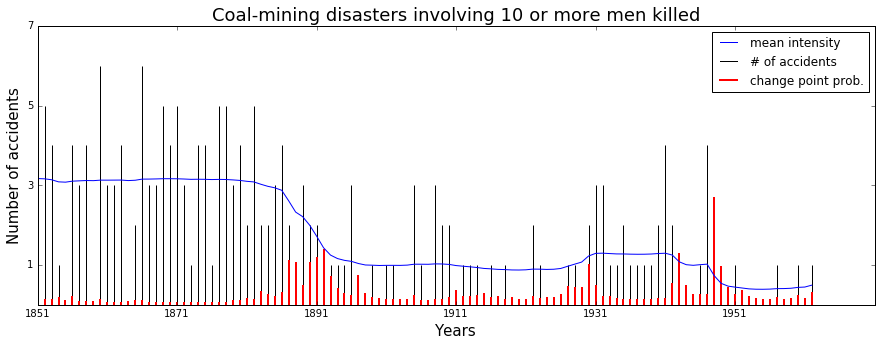

In [4]:
def plot_coal_mining(accidents, cpps=[], mean=[]):
    plt.figure(figsize=(15,5)) 
    ylim_ = np.max(accidents)*1.1
    K = len(accidents)
    plt.ylim([0,ylim_])
    a = plt.vlines(np.arange(K), np.zeros(K), accidents, label="# of accidents")
    if len(cpps)>0:
        h = plt.vlines(np.arange(0, K), np.zeros(K), np.array(cpps)*ylim_, 
                        colors='r', linestyles='-', linewidth=2, label="change point prob.")
    if len(mean)>0:
        m, = plt.plot(np.arange(K), mean, label="mean intensity")
    plt.title("Coal-mining disasters involving 10 or more men killed", fontsize=18)
    plt.ylabel("Number of accidents", fontsize=15)
    plt.xlabel("Years", fontsize=15)
    plt.xticks(np.arange(6)*20,np.arange(6)*20+1851)
    plt.yticks(np.arange(4)*2+1,np.arange(4)*2+1)
    plt.legend()

# load data
accidents = load_txt("../etc/coal_mining_accidents.txt")
accidents_as_matrix = accidents.reshape((1,-1))
print(accidents)

# init model params 
pi = 0.05
alpha = np.asarray([])
a = np.asarray([1])
b = np.asarray([2])

# run the model
model = Model(pi, alpha, a, b) 
result = model.smooth(accidents_as_matrix)
plot_coal_mining(accidents,result.cpp, result.mean)

### Well-Log Data (execution via C++)

Compiling C++ codes...
Running C++ codes...


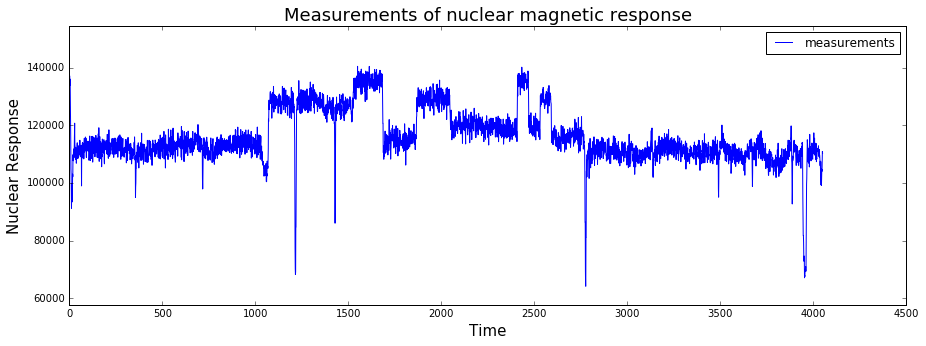

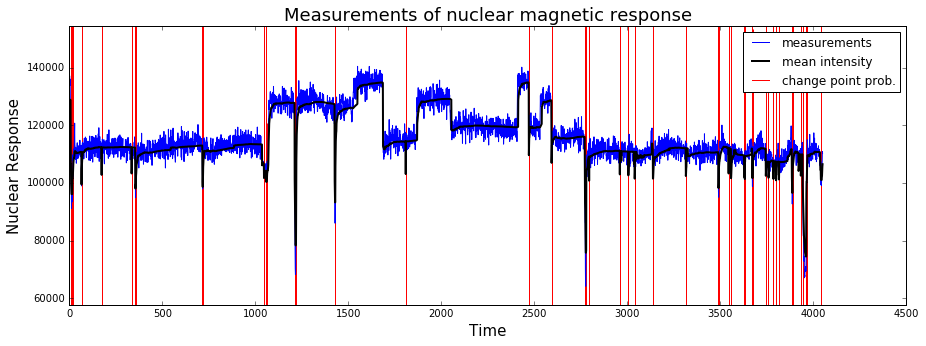

In [5]:
def plot_well_log(data, cpps=[], mean=[]):
    plt.figure(figsize=(15,5)) 
    ylim_max = np.max(data)*1.1
    ylim_min = np.min(data)*0.9
    K = len(data)
    plt.ylim([ylim_min, ylim_max])
    a = plt.plot(np.arange(K), data, 'b-', label="measurements")
    if len(cpps)>0:
        h = plt.vlines(np.arange(0, K), np.zeros(K), np.array(cpps)*ylim_max, 
                        colors='r', linestyles='-', label="change point prob.")
    if len(mean)>0:
        m, = plt.plot(np.arange(K), mean, 'k-', linewidth=2, label="mean intensity")
    plt.title("Measurements of nuclear magnetic response", fontsize=18)
    plt.ylabel("Nuclear Response", fontsize=15)
    plt.xlabel("Time", fontsize=15)
    plt.legend()
    

'''These data are 4050 measurements of nuclear magnetic
response taken during the drilling of a well. The data
are used to interpret the geophysical structure of the 
rock surrounding the well. The variations in mean
reflect the stratification of the earth’s crust.'''

work_dir = '/tmp/well_log'
find_or_create(work_dir)

data_dir = os.path.join(work_dir, 'data')

# Load Data
well_log_data = load_txt("../etc/well_log.txt")
data = Data()
data.v = well_log_data.reshape((1, -1))
data.save(data_dir)
plot_well_log(well_log_data)

# init model 
pi = 1e-5
alpha = np.asarray([])
a = np.asarray([1e5])
b = np.asarray([1])
model = Model(pi, alpha, a, b) 
model.save(work_dir + '/model.txt')

# run the model via C++ library
import os
# compile 
print('Compiling C++ codes...')
os.system("(cd ../cpp/; ./compile)")
# run
print('Running C++ codes...')
os.system("(cd ../cpp/bin/; ./runner " + work_dir + " online_smoothing)")
# load and visualize results
cpp_result = Result.load(os.path.join(work_dir + '/cpp/online_smoothing'))
plot_well_log(well_log_data, cpps=cpp_result.cpp, mean=cpp_result.mean.squeeze())


# Inference
Provided that the model parameters $w$ and $\pi$ are known, we can calculate the posterior marginals of the hidden variables $s_{1:T}$, and $h_{0:T}$, therefore detect the change points, via forward-backward algorithm. 

## Forward Recursion
Forward recursion allows us to infer the probability distribution over latent states ${s_t, h_t}$ conditioned on all observations until time $t$. In order to formulate the recursion, we need to define two variables:

\begin{align}
	\alpha_{t|t}(s_t, h_t) &= p(s_t, h_t, v_{1:t}) \\
	\alpha_{t|t-1}(s_t, h_t) &= p(s_t, h_t, v_{1:t-1})
\end{align}

These are refered as _forward_ and _forward-predict_ variables, respectively. What is called filtering change point posterior $p(s_t|v_{1:T})$ at time $t$ is then proportional to the forward message:
\begin{align}
	 p(s_t | v_{1:t}) &= \int_{h_t} p(s_t, h_t| v_{1:t}) \\
	 &\propto \int_{h_t} \alpha_{t|t}(s_t, h_t)
\end{align}
As new observations arrive, forward-predict and forward messages are alternatively calculated and the posterior probabilities of latent states as propagated as follows:

\begin{align}
	\alpha_{t|t}(s_t, h_t) &= p(s_t, h_t, v_{1:t}) \\
    &= p(v_t | s_t, h_t) \underbrace{ p(s_t, h_t, v_{1:t-1})}_{\alpha_{t|t-1}(s_{t-1}, h_{t-1})} \\
    &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} p(s_{t-1}, h_{t-1}, s_t, h_t, v_{1:t-1}) \\
    &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} p(s_{t-1}, h_{t-1}, v_{1:{t-1}}) p(s_t, h_t | s_{t-1},h_{t-1}) d h_{t-1}\\
    &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} \alpha_{t-1|t-1}(s_{t-1}, h_{t-1}) p(h_t | s_{t},h_{t-1})p(s_t) d h_{t-1}\\
    &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} \alpha_{t-1|t-1}(s_{t-1}, h_{t-1}) \Big( \Big. \delta(h_{t}-h_{t-1})p(s_t=0) + p(h_t)p(s_t=1)  \Big. \Big) d h_{t-1} 
\end{align}


## Backward Recursion
Derivation of backward recursion is very similar to that of forward recursion. Let us again define the backward messages:

\begin{align}
\beta_{t-1|t}(s_{t-1}, h_{t-1}) &= p(v_{t:T} | s_{t-1}, h_{t-1}) \\
\beta_{t|t}(s_{t}, h_{t}) &= p(v_{t:T} | s_{t}, h_{t}) 
\end{align}

Above messages are referred as _beta-postdict_ and _beta_ messages. Product of beta-postdict message and the observation model gives the beta message as shown below:

\begin{align}
\beta_{t|t}(s_{t}, h_{t}) &= \beta_{t|t+1}(s_{t}, h_{t}) p(v_{t} | h_{t})
\end{align}

We now examine the backward propagation step, which is slightly more complex than forward recursions:

\begin{align}
\beta_{t-1|t}(s_{t-1}, h_{t-1}) &= p(v_{t:T}|s_{t-1}, h_{t-1}) \\
&= \sum_{s_{t}} \int_{h_{t}} p(v_{t:T}, s_{t},h_{t}|s_{t-1}, h_{t-1}) d h_{t} \\ 
&= \sum_{s_{t}} \int_{h_{t}} p(v_{t:T}| s_{t},h_{t}) p(s_t,h_t|s_{t-1}, h_{t-1}) d h_{t} \\ 
&= \sum_{s_{t}} \int_{h_{t}} \beta_{t|t}(s_{t}, h_{t}) p(h_{t} | s_{t}, h_{t-1}) p(s_{t}) d h_{t} \\
&= \int_{h_{t}}  \beta_{t|t}(s_{t}, h_{t}) \Big(  \delta(h_{t}-h_{t-1})p(s_{t}=0) + p(h_{t})p(s_{t}=1) \Big) d h_{t}
\end{align}


## Smoothing
The posteriors probabilities can be obtained by multiplying forward and backward messages:

\begin{align}
p(s_t, h_t|v_{1:T}) &\propto  p(s_t, h_t,v_{1:T}) \\
&= p(s_t, h_t, v_{1:t}) p(v_{t+1:T} | s_t, h_t, v_{1:t}) \\
&= p(s_t, h_t, v_{1:t}) p(v_{t+1:T} | s_t, h_t) \\
&= \alpha_{t|t}(s_t, h_t) \beta_{t|t+1}(s_t, h_t)
\end{align}

If the inference task is online, calculating posterior probabilities conditioned on the full history becomes infeasible. This is because the cost of executing backward recursions increases linearly with time, and backward recursions must be executed at each new observation. For online problems we typically use **fixed lag smoothers**, in which a fixed number of backward recursions are performed so that the computational complexity would be independent of time. This fixed number is known as **lag**. If the lag is $L$, posterior probabilities at time $t$ is calculated conditioned on the observations up to time $t+L$:

\begin{align}
	p(s_t, h_t, v_{1:t+L}) &= p(s_t, h_t, v_{1:t}) p(v_{t+1:t+L} | s_t, h_t) 
\end{align}

The second expression on the right hand side of the equality is computed by executing backward recursions for $L$ steps, starting from the observation at time $t+L$.


## Complexity Analysis of Forward-Backward
When the state space of $h_t$ is discrete, the model reduces to classical HMMs. In this case, the latent state space is simply the Cartesian product of those of $s_t$ and $h_t$. That is to say, forward variables are $2\times |h_t|$ dimensional matrices, where $|h_t|$ denotes the length of the hidden variable. 

When $h_t$ is continuous, however, inference would be different than HMMs. At first glance, the inference might seem to be intractable since we try to sum over exponentially many switch settings to calculate the posterior. However, thanks to the forgetting property of the model, it is possible to implement forward-backward routine efficient, i.e., quadratic with the number of observations $T$. We first define the two components of the forward message given above as follows: 

\begin{align}
p(s_t=0, h_t, v_{1:t}) &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} p(s_{t-1}, h_{t-1}, v_{1:t-1}) \delta(h_{t}-h_{t-1})p(s_t=0) d h_{t-1}  \\ 
p(s_t=1, h_t, v_{1:t}) &= p(v_t | h_t) \sum_{s_{t-1}} \int_{h_{t-1}} p(s_{t-1}, h_{t-1}, v_{1:t-1}) p(h_t)p(s_t=1) d h_{t-1} \\
&= p(v_t | h_t) p(v_{1:t-1}) p(h_t)p(s_t=1)
\end{align}

In our terminology, the first term $p(s_t=0, h_t, v_{1:t})$ above corresponds to _no-change_ and the second term is refered as _change_ case. In a no-change case, the forward message at time $t-1$ is multiplied by observation probability and change point prior. Informally speaking, probability distribution over $h_{t-1}$ is updated and _transferred_ to $h_{t}$, due to the integral and Dirac delta function. In a change case however, $p(h_t)$ is reset to $\Omega(h_t;w)$, meaning it is a single component whose parameter is independent of previous message. 

Overall, the forward message $\alpha_{t|t}(s_t, h_t)$ is computed by updating the previous message (formulated in no-change case) and adding one more component (change case). Therefore, if $\alpha_{t-1|t-1}(s_{t-1}, h_{t-1})$ is a mixture with $K$ components, the next forward message would have $K+1$ components. In other words, the number of components grows only linearly with time, and the complexity of forward recursions becomes $O(T^2)$. Although the computational effort is far less than exponential, filtering is still too expensive for long time series. An approximation to the exact posterior could be performed by setting an upper limit on the number of mixture components. This can be done by eliminating the component with the smallest normalization constant after each update step. Empirically, we observe that keeping only 50 components while doing the inference on time series consisting of 2000-3000 observations would be sufficient.